## MinK++ Plotting

In [1]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math

In [2]:
source = 'results/time_travel/'
metric = 'bleurt' 
# metric = 'rouge'
metric_1 = f"{metric}_score_for_general_completion"
metric_2 = f"{metric}_score_for_guided_completion"

In [3]:
# Function to remove outliers based on the 2.5th and 97.5th percentiles
def remove_outliers(df, column_name):
    lower_quantile = df[column_name].quantile(0.025)
    upper_quantile = df[column_name].quantile(0.975)
    return df[(df[column_name] >= lower_quantile) & (df[column_name] <= upper_quantile)]

In [4]:
dataframes = []

for subfolder in ['mamba_2.7b', 'OPT_2.7b', 'OLMo_1b', 'OLMo_7b']: #os.listdir(source):
  subfolder_path = os.path.join(source, subfolder)
  if os.path.isdir(subfolder_path):  # Check if it's a directory
    for sub_subfolder in os.listdir(subfolder_path):
      sub_subfolder_path = os.path.join(subfolder_path, sub_subfolder)
      if os.path.isdir(sub_subfolder_path):  # Check if it's a directory
        csv_file_path = os.path.join(sub_subfolder_path, "df.csv")
        if os.path.exists(csv_file_path):  # Check if df.csv exists
          # Load the CSV into a DataFrame
          df = pd.read_csv(csv_file_path)
          df = df[[metric_1, metric_2]]
          df['Dataset'] = sub_subfolder
          df['Model'] = subfolder

          df = remove_outliers(df, metric_1)
          df = remove_outliers(df, metric_2)
          
          dataframes.append(df)
          print(f"Loaded DataFrame from: {csv_file_path}")
        else:
          print(f"No df.csv found in: {sub_subfolder_path}")

Loaded DataFrame from: results/time_travel/mamba_2.7b/anli/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/scitail/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/paws/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/snli/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/wnli/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/hans/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/mnli/df.csv
Loaded DataFrame from: results/time_travel/mamba_2.7b/rte/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/anli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/scitail/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/paws/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/snli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/wnli/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/hans/df.csv
Loaded DataFrame from: results/time_travel/OPT_2.7b/mnli/df.csv
Loaded DataFrame fr

In [5]:
# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Prepare the data for the violin plot
datasets = ['scitail', 'mnli', 'paws', 'hans'] #combined_df['Dataset'].unique()
# datasets = list(set(combined_df['Dataset'].unique()) - set(datasets))
models = combined_df['Model'].unique()

# Create a dictionary to hold data for each dataset and model
violin_data_left = []  # For the "general" side (left part)
violin_data_right = []  # For the "guided" side (right part)
dataset_positions = []
colors = plt.cm.tab10.colors  # Use a colormap for different model colors
model_color_map = {model: colors[i % len(colors)] for i, model in enumerate(models)}

current_position = 1
position_labels = []
position_models = []
for dataset in datasets:
    model_positions = []
    for model in models:
        subset = combined_df[(combined_df['Dataset'] == dataset) & (combined_df['Model'] == model)]
        if not subset.empty:
            # Left part: "general" score
            violin_data_left.append(subset[metric_1].values)
            # Right part: "guided" score
            violin_data_right.append(subset[metric_2].values)
            
            model_positions.append(current_position)
            position_models.append(current_position)
            current_position += 1
    # Calculate the midpoint of the model positions for the dataset
    if model_positions:
        dataset_positions.append(sum(model_positions) / len(model_positions))
        position_labels.append(dataset)
    current_position += 2

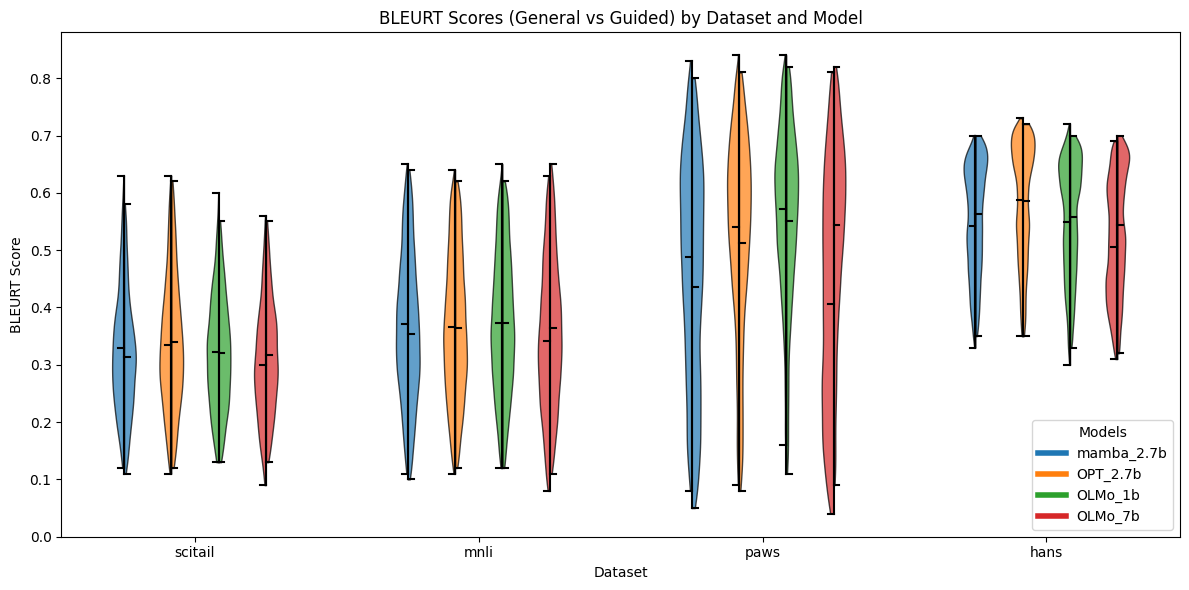

In [11]:
# Create the violin plot for both general and guided rouge scores
fig, ax = plt.subplots(figsize=(12, 6))

# Plot "general" (left) violins
violin_parts_left = ax.violinplot(violin_data_left, positions=position_models, side='low', showmeans=True, showextrema=True, showmedians=False)

# Plot "guided" (right) violins
violin_parts_right = ax.violinplot(violin_data_right, positions=position_models, side='high', showmeans=True, showextrema=True, showmedians=False)

for line_type in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if line_type in violin_parts_left:
        violin_parts_left[line_type].set_color('black')

for line_type in ['cmeans', 'cmins', 'cmaxes', 'cbars']:
    if line_type in violin_parts_right:
        violin_parts_right[line_type].set_color('black')

# Add colors to the violins for the left side (general)
for i, pc in enumerate(violin_parts_left['bodies']):
    model = models[i % len(models)]  # Cycle through models
    pc.set_facecolor(model_color_map[model])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add colors to the violins for the right side (guided)
for i, pc in enumerate(violin_parts_right['bodies']):
    model = models[i % len(models)]  # Cycle through models
    pc.set_facecolor(model_color_map[model])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Customize the X-axis
ax.set_xticks(dataset_positions)
ax.set_xticklabels(datasets, rotation=0)
ax.set_xlabel("Dataset")
ax.set_ylabel(f"BLEURT Score")
ax.set_title(f"BLEURT Scores (General vs Guided) by Dataset and Model")

# Add a legend for the models
handles = [plt.Line2D([0], [0], color=model_color_map[model], lw=4, label=model) for model in models]
ax.legend(handles=handles, title="Models", loc="lower right")

plt.tight_layout()
plt.show()

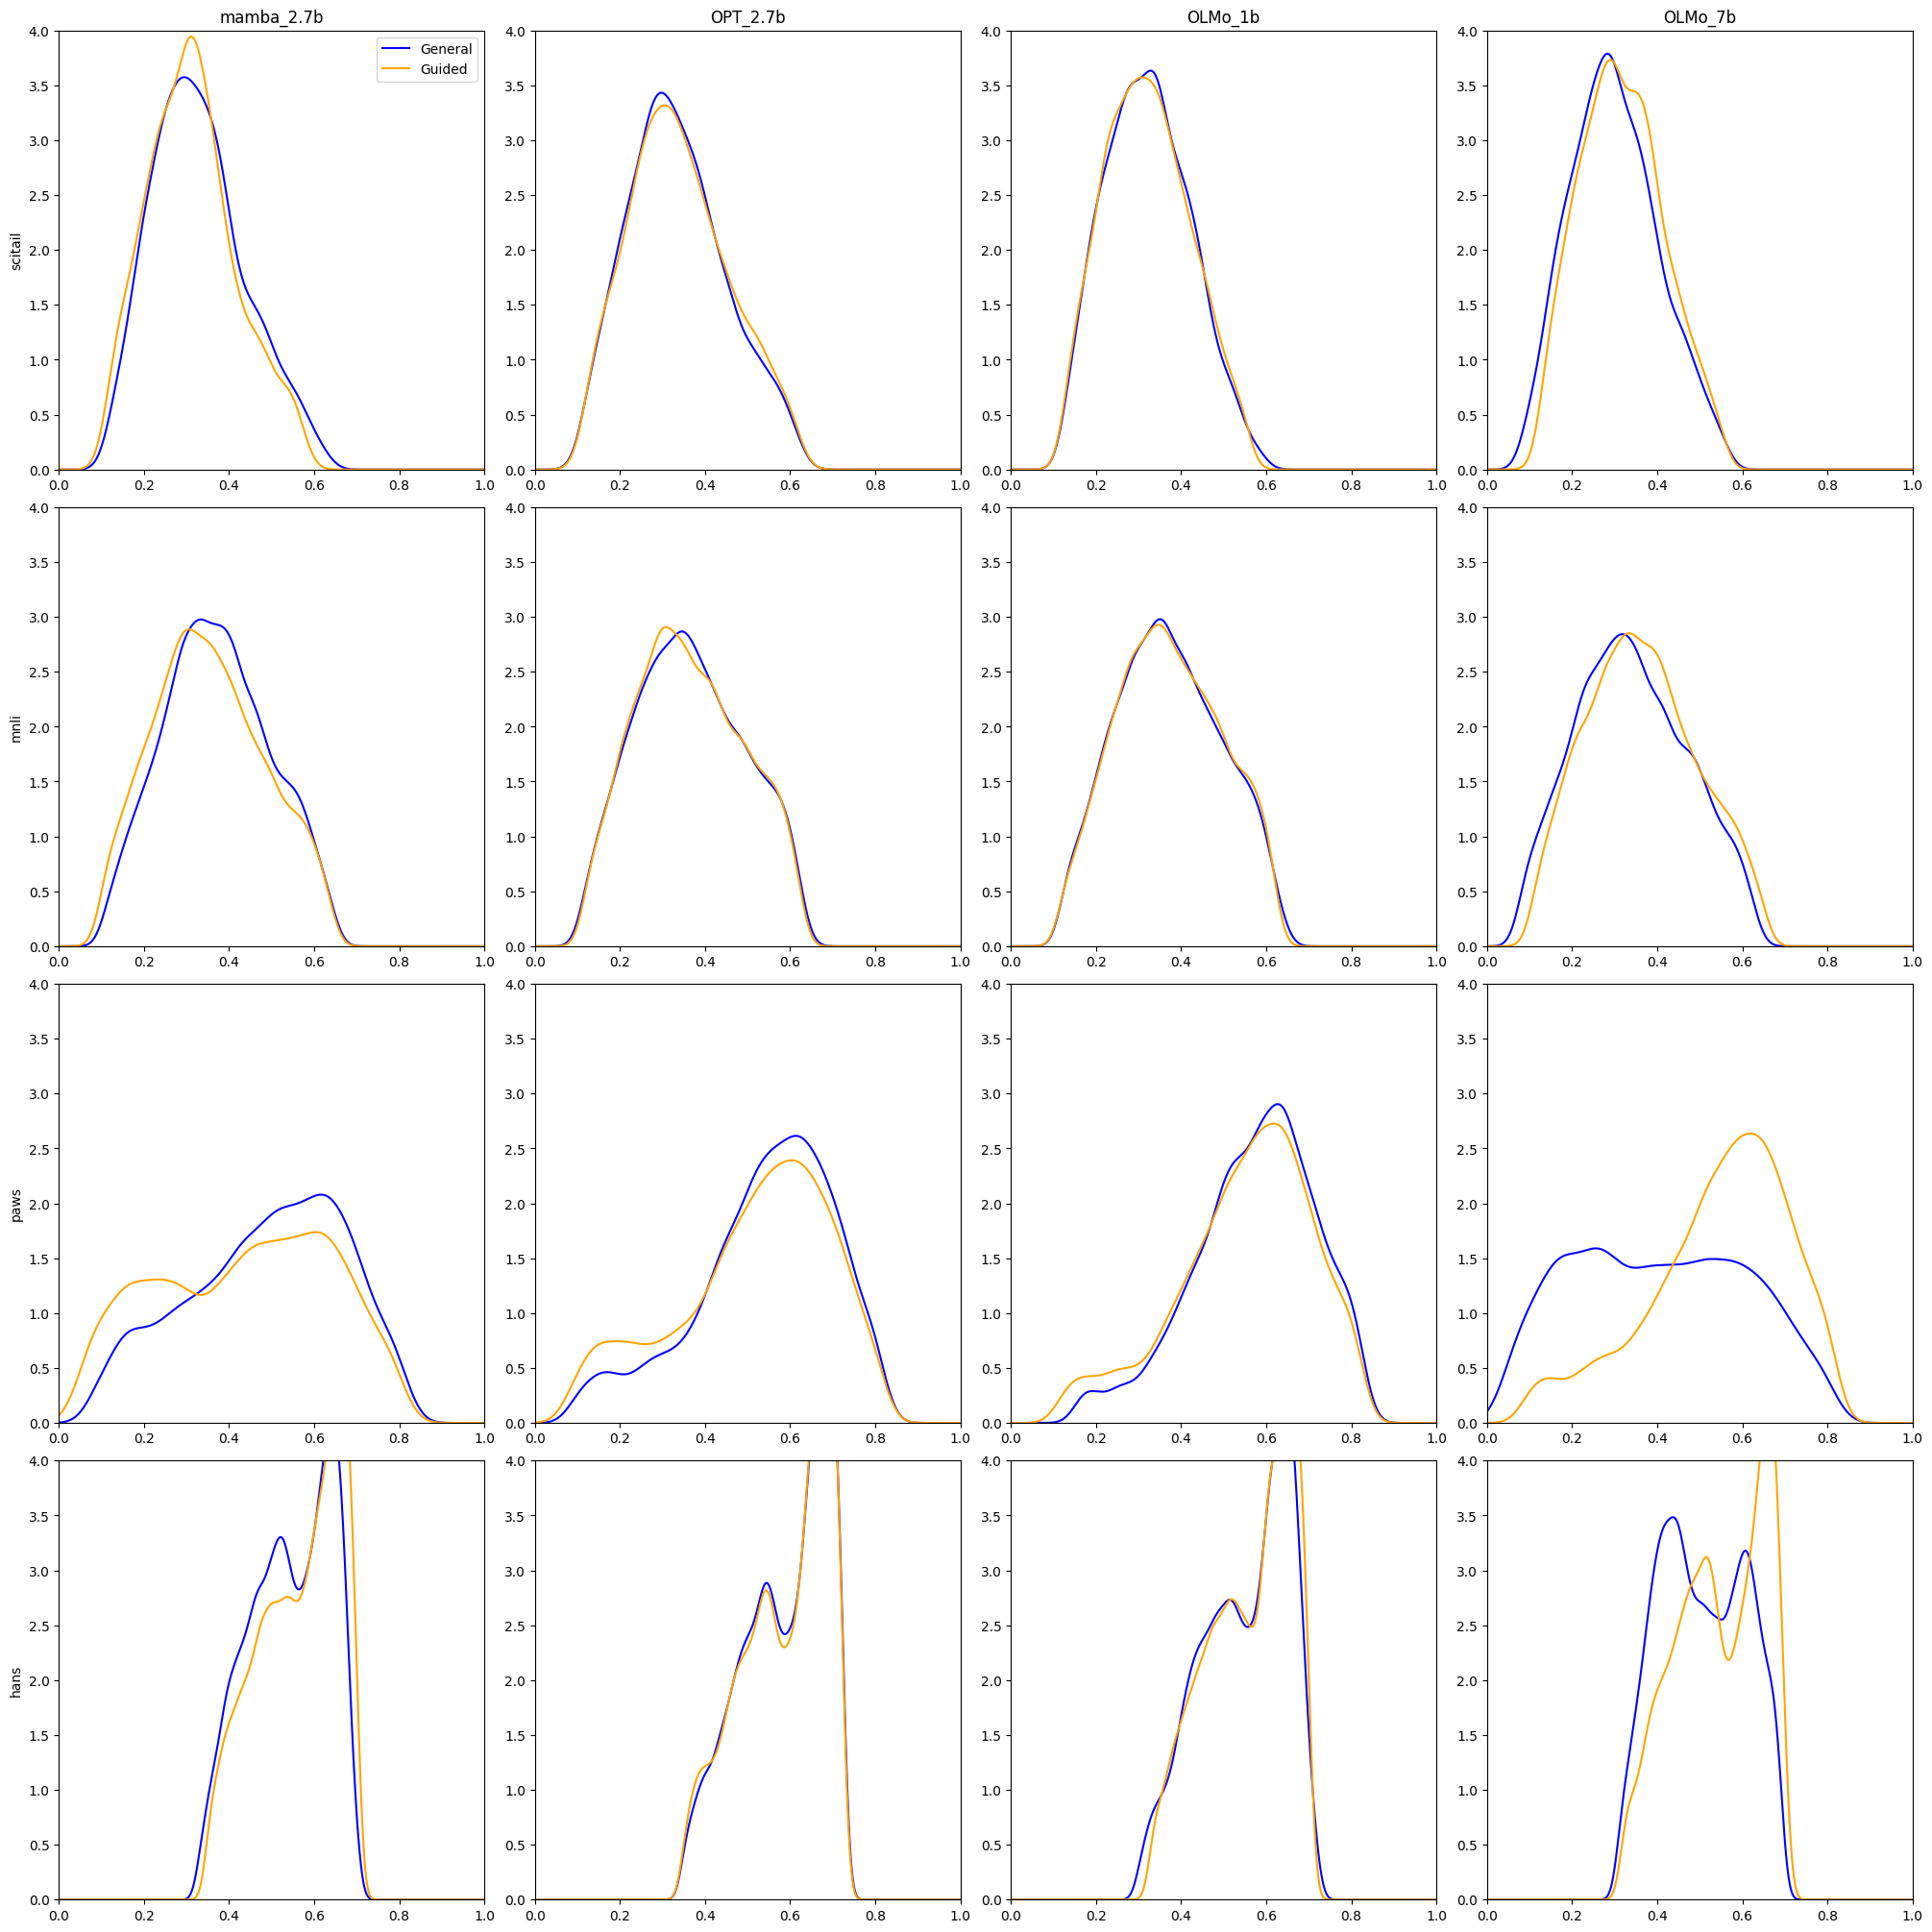

In [7]:
# Number of datasets
num_datasets = len(violin_data_left)

# Create subplots
cols = 4  # Number of subplots per row
rows = (num_datasets + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), constrained_layout=True)

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each dataset in its own subplot
for i in range(num_datasets):
    ax = axes[i]
    
    # Estimate the probability density function using gaussian_kde
    density1 = gaussian_kde(violin_data_left[i])
    density2 = gaussian_kde(violin_data_right[i])

    # Create a range of values over which to evaluate the density
    x = np.linspace(0, 1, 1000)

    # Plot the distributions as lines
    ax.plot(x, density1(x), label='General', color='blue')
    ax.plot(x, density2(x), label='Guided', color='orange')

    # Add labels, title, and legend
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 4)

    # if i%4 != 0: 
    #     ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    # if i < num_datasets-cols: 
    #     ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # ax.set_xlabel('Value')
    if i < cols: ax.set_title(models[i])
    if i%4 == 0: ax.set_ylabel(datasets[math.floor(i/4)])
    if i == 0: 
        ax.legend()

# Hide any unused subplots
for i in range(num_datasets, len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

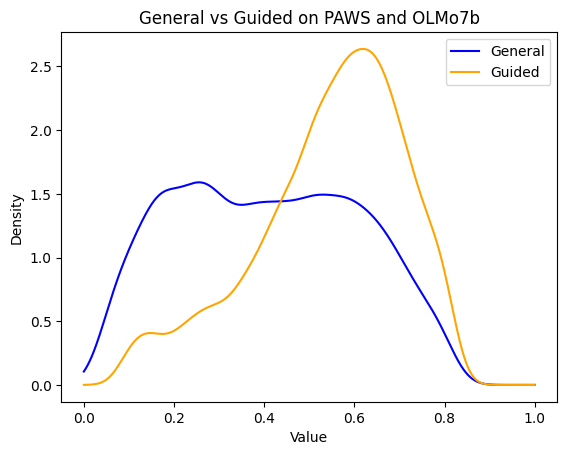

In [14]:
# Estimate the probability density function using gaussian_kde
density1 = gaussian_kde(violin_data_left[11])
density2 = gaussian_kde(violin_data_right[11])

# Create a range of values over which to evaluate the density
x = np.linspace(0, 1, 1000)

# Plot the distributions as lines
plt.plot(x, density1(x), label='General', color='blue')
plt.plot(x, density2(x), label='Guided', color='orange')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('General vs Guided on PAWS and OLMo7b')

# Add legend
plt.legend()

# Display the plot
plt.show()